Characterizing noisy circuit using GHZ state : https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html

The Qiskit Aer noise module contains Python classes to build customized noise models for simulation. There are three key classes:

    1.The NoiseModel class which stores a noise model used for noisy simulation.

    2.The QuantumError class which describes completely positive and trace-preserving (CPTP) gate errors. These can be applied:

        After gate or reset instructions

        Before measure instructions.

    3. The ReadoutError class which describes classical readout errors.


In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram


# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

Example 1:construct a 5% single-qubit Bit-flip error:

In [2]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [3]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [4]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


step 1: Create GHZ state

In [5]:
# System Specification
n_qubits = 4
circuit2 = QuantumCircuit(n_qubits)

# Test Circuit
circuit2.h(0)
for qubit in range(n_qubits - 1):
    circuit2.cx(qubit, qubit + 1)
    circuit2.h(qubit)
    
circuit2.h(3)
circuit2.measure_all()
print(circuit2)

        ┌───┐     ┌───┐           ░ ┌─┐         
   q_0: ┤ H ├──■──┤ H ├───────────░─┤M├─────────
        └───┘┌─┴─┐└───┘┌───┐      ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■──┤ H ├──────░──╫─┤M├──────
             └───┘┌─┴─┐└───┘┌───┐ ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■──┤ H ├─░──╫──╫─┤M├───
                  └───┘┌─┴─┐├───┤ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├┤ H ├─░──╫──╫──╫─┤M├
                       └───┘└───┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════╩══╩══╩══╩═
                                     0  1  2  3 


In [6]:
#circuit2.draw(output='mpl')

step2: Ideal Simulation

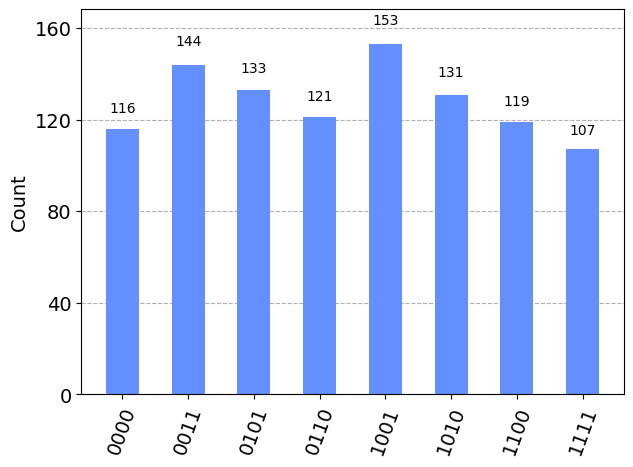

In [7]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
job_ideal=sim_ideal.run(circuit2)
result_ideal =job_ideal.result()
counts_ideal=result_ideal.get_counts()
plot_histogram(counts_ideal)

Noise Example 1: Basic bit-flip error noise model¶

Lets consider a simple toy noise model example common in quantum information theory research:

    When applying a single qubit gate, flip the state of the qubit with probability p_gate1.

    When applying a 2-qubit gate apply single-qubit errors to each qubit.

    When resetting a qubit reset to 1 instead of 0 with probability p_reset.

    When measuring a qubit, flip the state of the qubit with probability p_meas.


In [8]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'reset', 'measure', 'u2', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


Executing the noisy simulation

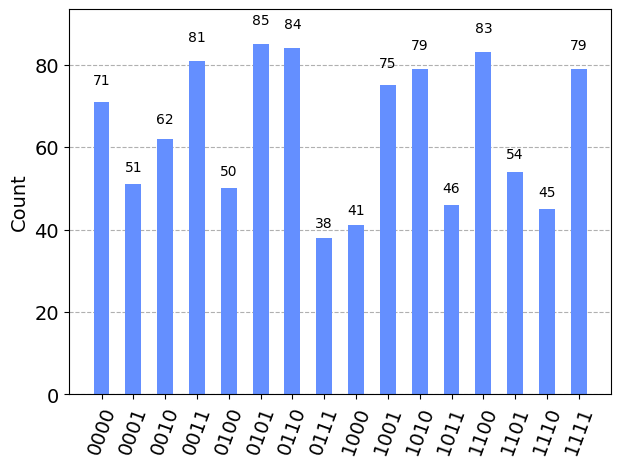

In [9]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circuit2, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)
